<a href="https://colab.research.google.com/github/timeslump/bppestimater/blob/main/bpp_estimater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

import numpy as np
import os 

from keras.layers import BatchNormalization, Dropout
%matplotlib inline

In [ ]:
#from google.colab import drive
#!gdown --id 1hGGKKIeGFP9UNchNyTyUxBYI-WiI3oZ8


In [ ]:
#!unzip /content/data.zip &> /dev/null

In [ ]:
X = []
Y = []
path = '/content/test'
files = os.listdir(path)
for file in files:
  data = np.load(path + '/' +file)
  bpp = float(file.split('-')[1].split('.npy')[0])
  X.append(data)
  Y.append(float(bpp))

In [ ]:
X_new = np.array(X).reshape(-1, 3, 4, 4, 64)
y_new = np.array(Y)
Y_new = np.expand_dims(y_new, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=22)

In [ ]:
X_train1 = []
X_train2 = []
X_test1 = []
X_test2 =[]
for data in X_train:
  for i in range(3):
    for j in range(4):
      for k in range(4):
        X_train1.append(data[i, j, k, 0])
        X_train2.append(data[i, j,k, 1:])

X_train1= np.array(X_train1).reshape(-1, 48)
X_train2 = np.array(X_train2).reshape(-1, 63, 48)
for data in X_test:
  for i in range(3):
    for j in range(4):
      for k in range(4):
        X_test1.append(data[i, j, k, 0])
        X_test2.append(data[i, j, k, 1:])
X_test1= np.array(X_test1).reshape(-1, 48)
X_test2 = np.array(X_test2).reshape(-1, 63, 48)


In [ ]:
import keras 
from keras.layers import Input, LSTM, Dense, Bidirectional, TimeDistributed, Flatten
from keras.models import Model

main_input = Input(shape=(63, 48), dtype='float32', name='main_input')
#Model 1
lstm_out = Bidirectional(LSTM(128,input_shape=(63, 48), return_sequences=True))(main_input)
x_layer = TimeDistributed(Dense(1))(lstm_out)
x =  Flatten()(x_layer)

'''
#Mode 2 
x =  Flatten()(main_input)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
'''



#common
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

x_output = Dense(1, activation='relu')(x)
x_output = Flatten()(x_output)

auxiliary_input = Input(shape=(48,), name='auxiliary_input')
y = Dense(32, activation='relu')(auxiliary_input)
y = Dense(16, activation='relu')(auxiliary_input)
y = Dense(8, activation='relu')(y)
y = Dense(4, activation='relu')(y)
y = Dense(2, activation='relu')(y)
y_output = Dense(1, activation='relu')(y)

concatenated = keras.layers.concatenate([x_output, y_output])
output = Dense(1, activation='relu', name = 'output')(concatenated)
model = Model([main_input, auxiliary_input], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 63, 48)]     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 63, 256)      181248      main_input[0][0]                 
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 63, 1)        257         bidirectional_1[0][0]            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 63)           0           time_distributed_1[0][0]         
____________________________________________________________________________________________

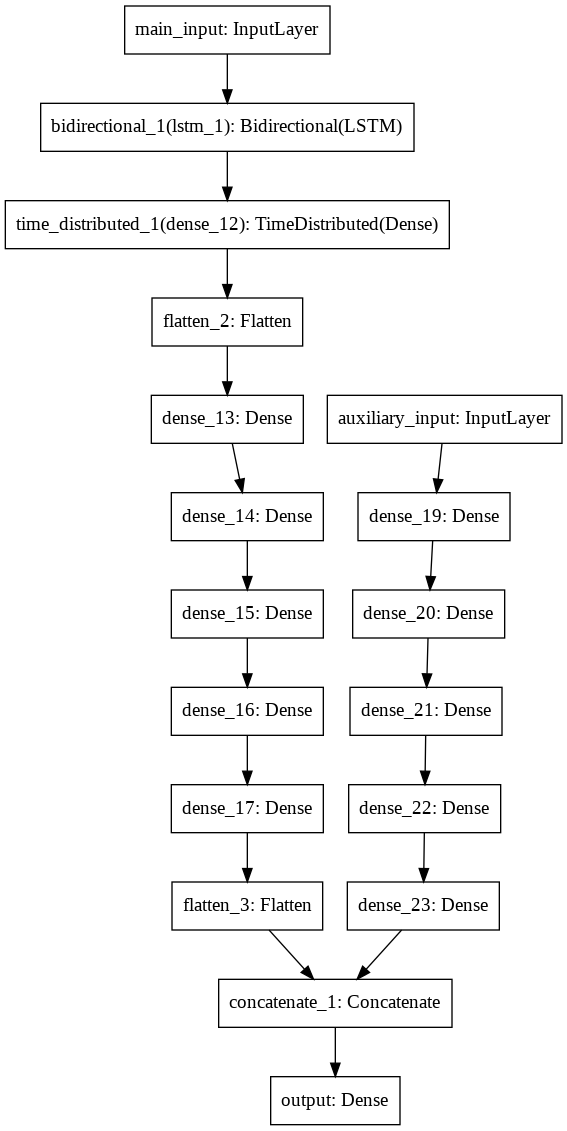

In [ ]:
keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mape'])

In [ ]:
from keras.callbacks import EarlyStopping

EPOCHS = 100
BATCH_SIZE = 64
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit([X_train2, X_train1], y_train,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=([X_test2,X_test1], y_test),
                    validation_steps=len(X_test) // BATCH_SIZE,
                    callbacks=[es])

Epoch 1/100
153/153 [==============================] - 41s 241ms/step - loss: 6.3997 - mape: 46.6003 - val_loss: 0.3500 - val_mape: 13.5003
Epoch 2/100
153/153 [==============================] - 36s 237ms/step - loss: 0.2176 - mape: 11.7374 - val_loss: 0.1801 - val_mape: 8.7460
Epoch 3/100
153/153 [==============================] - 36s 238ms/step - loss: 0.1134 - mape: 7.6131 - val_loss: 0.1117 - val_mape: 7.0982
Epoch 4/100
153/153 [==============================] - 37s 239ms/step - loss: 0.0719 - mape: 6.2558 - val_loss: 0.0894 - val_mape: 5.9834
Epoch 5/100
153/153 [==============================] - 36s 238ms/step - loss: 0.0498 - mape: 5.2196 - val_loss: 0.0832 - val_mape: 5.6871
Epoch 6/100
153/153 [==============================] - 36s 237ms/step - loss: 0.0377 - mape: 4.6903 - val_loss: 0.0723 - val_mape: 5.8944
Epoch 7/100
153/153 [==============================] - 37s 243ms/step - loss: 0.0292 - mape: 4.3746 - val_loss: 0.0787 - val_mape: 5.4298
Epoch 8/100
153/153 [==========

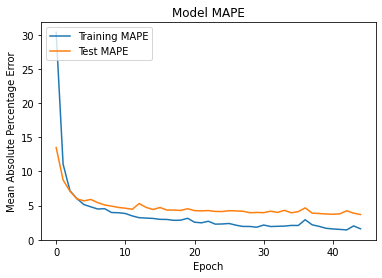

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('Model MAPE')
plt.ylabel('Mean Absolute Percentage Error')
plt.xlabel('Epoch')
plt.legend(['Training MAPE', 'Test MAPE'], loc='upper left')
plt.show()

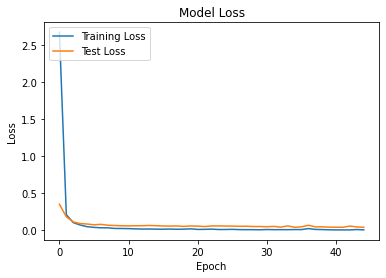

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
#preds = model.predict(X_test)
#acc = accuracy_score(y_test, np.round(preds))*100
#print('Accuracy: {}%'.format(acc))